# Build and train model

In this notebook an ElasticNet Model will be created and trained. The accuracy of the model will be evaluated through the four selected metrics: *mean squared error*, *root mean squared error*, *mean absolute error* and *mean absolute percentage error*.

After the evaluation of the models using the validation data the best fitting model will be exported for later use in [this](./demo.ipynb) notebook.

In [1]:
# install packages, if they are not installed
import sys
import subprocess
import pkg_resources

required = {'pandas', 'numpy', 'matplotlib', 'mlflow', 'scikit-learn'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout = subprocess.DEVNULL)

# import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mlflow
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error

import logging
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

import warnings
warnings.filterwarnings("ignore")

## Data

In [2]:
# get data from git repository
#csv_url = 'https://raw.githubusercontent.com/Jas53/Data_Exploration_Project/main/data/WorldHappinessReport/2019.csv?token=GHSAT0AAAAAABRTCQJSXY2MLH74DIOZQA2UYQOB2QQ'
#df = pd.read_csv(csv_url)
df = pd.read_csv('./data/WorldHappinessReport/2019.csv')
# set new index for DataFrame
df.set_index('Country or region', inplace = True)
df.head()

,Overall rank,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
Country or region,,,,,,,,
Finland,1,7.769,1.340,1.587,0.986,0.596,0.153,0.393
Denmark,2,7.600,1.383,1.573,0.996,0.592,0.252,0.410
Norway,3,7.554,1.488,1.582,1.028,0.603,0.271,0.341
Iceland,4,7.494,1.380,1.624,1.026,0.591,0.354,0.118
Netherlands,5,7.488,1.396,1.522,0.999,0.557,0.322,0.298


We can see, that the data has eight columns - besides the column that is now used as the index.

The first column shows which place in the ranking between the countries the respective country took.</br>
The second column shows the score the respective country achieved.</br>
The last six columns indicate how much each column contributes to the calculation to the happiness score. Therefore all the six columns are used for predicting the score values.

In [3]:
# check if there are doubled countries
df.index.value_counts()

Finland                1
Venezuela              1
Jordan                 1
Benin                  1
Congo (Brazzaville)    1
                      ..
Latvia                 1
South Korea            1
Estonia                1
Jamaica                1
South Sudan            1
Name: Country or region, Length: 156, dtype: int64

**TAKEAWAY**</br>
There are no duplicates.

In [4]:
# check every feature if there are Null-Values
print(df.isnull().sum())

Overall rank                    0
Score                           0
GDP per capita                  0
Social support                  0
Healthy life expectancy         0
Freedom to make life choices    0
Generosity                      0
Perceptions of corruption       0
dtype: int64


**TAEKAWAY**</br>
There are no Null-Values in this dataset and all the data can be used, without further manipulation.

In [5]:
# define target feature and create feature list
target_feature = 'Score'
features_to_remove = [target_feature, 'Overall rank']
features = df.columns.to_list()
features = [feature for feature in features if feature not in features_to_remove]

The *'Score'* column is defined as the target feature, because we want to predict the happiness score for the specific countries.

Next all the other features - except for the *'Overall rank'* column - are put in a list. This list will be used to identify the features that will be used to predict the target feature.</br>
The column *'Overall rank*' will not be used for the prediction, because this data is based on the happiness score and therefore this info is just available after calculating the happiness score. Using this column would fake the outcome of the model and its calculations and would result in an overfitting model.

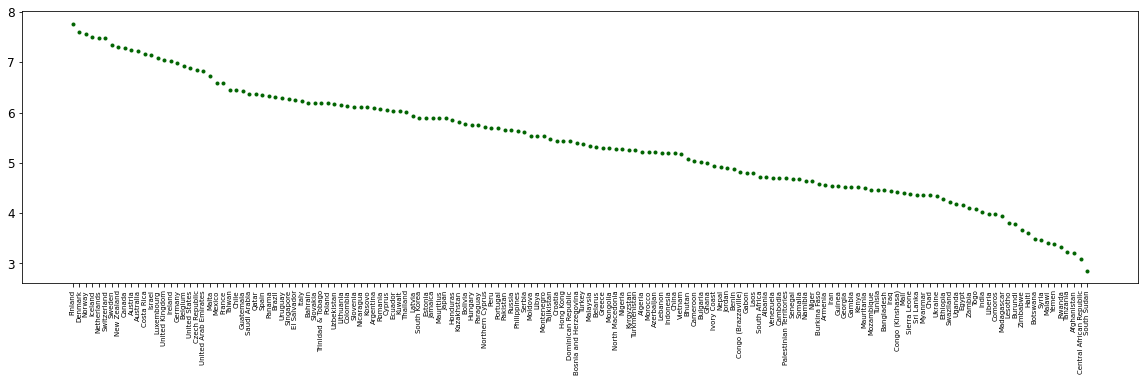

In [6]:
# plot the happiness-score for all the countries
fig, axs = plt.subplots(1, 1, figsize = (20, 5))
axs.scatter(df.index, df['Score'], color = 'darkgreen', marker = '.')
axs.tick_params(axis = 'x', rotation = 90, labelsize = 7)
axs.tick_params(axis = 'y', labelsize = 12)

In this graph we can see the happiness scores for all the countries in the data. Each country is represented with one datapoint. On the very left we can see Finland with the best happiness score and on the very right we can see south sudan with the worst happiness score.

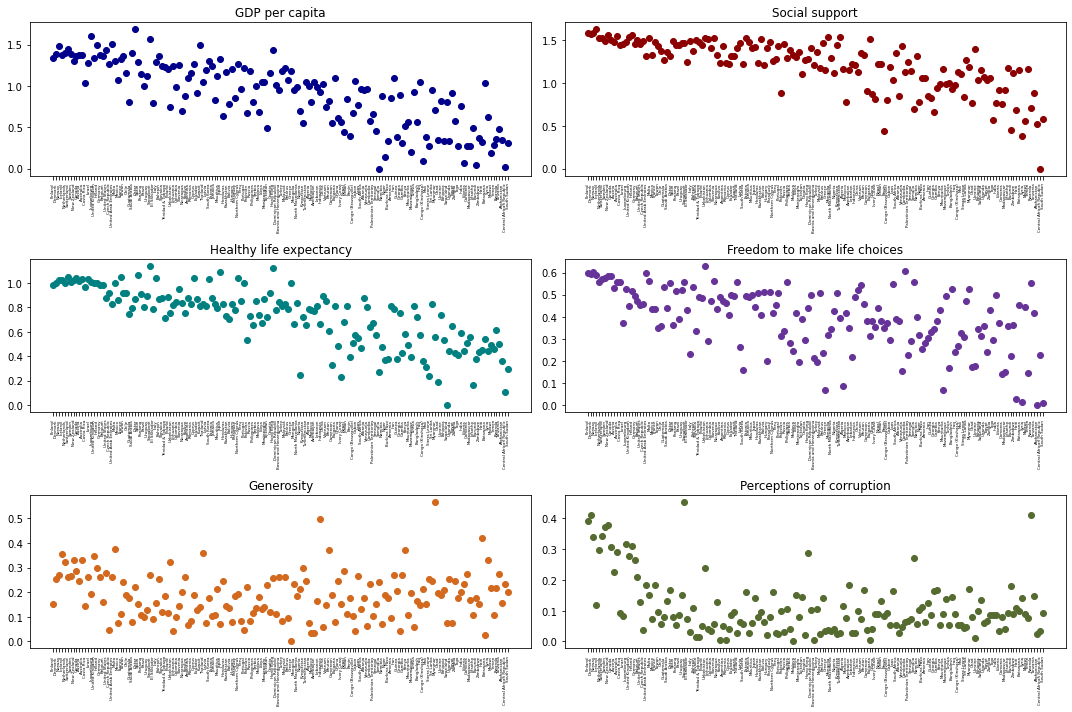

In [7]:
colors = ['darkblue', 'darkred', 'teal', 'rebeccapurple', 'chocolate', 'darkolivegreen']
rows = 3
cols = 2
i = 0
fig, axs = plt.subplots(rows, cols, figsize = (15, 10))

for row in range(rows):
    for col in range(cols):
        axs[row][col].scatter(df.index, df[features[i]], color = colors[i])
        axs[row][col].set_title(features[i])
        axs[row][col].tick_params(axis = 'x', rotation = 90, labelsize = 4)
        axs[row][col].tick_params(axis = 'y', labelsize = 10)
        i = i + 1

fig.tight_layout()

In these six plots we can see the distibution of the datapoints for each column that will be used to predict the happiness score.

## Split the data

In [8]:
# split all data in training and testing data (Size 90 / 10)
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target_feature], test_size = 0.1, random_state = 1)

# split training data into training and validating data (Size 75 / 25)
X_train, X_val, y_train, y_val = train_test_split(X_train[features], y_train, test_size = 0.25)

With these splits we habe ~67% (105 records) training data to train the model, ~23% (35 records) validating data to tune the hyperparameter and to optimize the model and ~10% (16 records) testing data to demonstrate the model in [this](./demo.ipynb). 

## Train the model

In [9]:
def calc_metrics(actual_data: pd.Series, prediction_data: np.ndarray):
    """
    calculate the different metrics (mean squared error, root mean squared error, mean absolute error 
        and mean absolute percentage error) to evaluate the model accuracy.
    
    Params:
        actual_data (Series): the actual imported data
        prediction_data (ndarray): the from the model predicted data
    
    Returns:
        mse (float): the calculated mean squared error value
        rmse (float): the calculated root mean squared error value
        mae (float): the claclulated mean absolute error value
        mape (float): the calculated mean absolute percentage error value
    """
    # calculate the four accuracy metrics
    mse = mean_squared_error(actual_data, prediction_data)
    rmse = mean_squared_error(actual_data, prediction_data, squared = False)
    mae = mean_absolute_error(actual_data, prediction_data)
    mape = np.mean(np.abs((actual_data - prediction_data) / actual_data)) * 100
    
    # print the calculated values
    print('########## METRICS ##########')
    print('MSE:\t%s\nRMSE:\t%s\nMAE:\t%s\nMAPE:\t%s' % (mse, rmse, mae, mape))
    
    return mse, rmse, mae, mape

In [10]:
def train(alpha: float = 1.0, l1_ratio: float = 0.5):
    """
    Train a model with the given parameters with the trainigns data and validate 
    the accuracy/errors of the model with the validation data
    
    Params:
        alpha (float): the value for the alpha parameter
        l1_ratio (float): the value for the l1_ratio parameter
    """
    with mlflow.start_run():
        # create model
        model = ElasticNet(alpha = alpha, l1_ratio = l1_ratio)
        # fit model
        model.fit(X_train, y_train)
        # predict 
        pred = model.predict(X_val)
        
        # print model parameter and calculated error metrics
        print('\n########## MODEL ##########')
        print('alpha:\t%s\nl1_ratio:\t%s' % (alpha, l1_ratio))
        mse, rmse, mae, mape = calc_metrics(y_val, pred)
        
        # log parameter
        mlflow.log_param("alpha", alpha)
        mlflow.log_param("l1_ratio", l1_ratio)
        # log metrics
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("mape", mape)
        
        #log model
        mlflow.sklearn.log_model(model, "model")

In [11]:
# set range of the parameters alpha and l1_ratio to test the model with different parameter and 
#  to identify the model with the best accuracy
alpha_values = [0.0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.25, 1.5, 1.75, 2.0]
l1_ratio_values = [0.0, 0.5, 1.0]

In [12]:
# create and train a model for every combination of the alpha and the l1_ratio parameter
for l1_ratio_value in l1_ratio_values:
    for alpha_value in alpha_values:
        train(alpha = alpha_value, l1_ratio = l1_ratio_value)


########## MODEL ##########
alpha:	0.0
l1_ratio:	0.0
########## METRICS ##########
MSE:	0.3156546865506447
RMSE:	0.561831546418181
MAE:	0.44017366562928095
MAPE:	9.299469857522821

########## MODEL ##########
alpha:	0.2
l1_ratio:	0.0
########## METRICS ##########
MSE:	0.4881867838111807
RMSE:	0.6987036451967177
MAE:	0.5794760342401759
MAPE:	12.136023625569688

########## MODEL ##########
alpha:	0.4
l1_ratio:	0.0
########## METRICS ##########
MSE:	0.6604551177525202
RMSE:	0.8126838978056107
MAE:	0.6918969914535958
MAPE:	14.384522936252269

########## MODEL ##########
alpha:	0.5
l1_ratio:	0.0
########## METRICS ##########
MSE:	0.7229627596726454
RMSE:	0.8502721679983684
MAE:	0.7296464013481302
MAPE:	15.133688691157287

########## MODEL ##########
alpha:	0.6
l1_ratio:	0.0
########## METRICS ##########
MSE:	0.7743065834497719
RMSE:	0.8799469208138476
MAE:	0.7587492411973856
MAPE:	15.711668317838503

########## MODEL ##########
alpha:	0.7
l1_ratio:	0.0
########## METRICS ##########
MSE:	0.

**TAKEAWAY**</br>
The best fitting model is the model with an the parameters alpha = 0.0 and l1_ratio = 0.0.

This means the model uses no regulation in combination with the L2-Norm.

This model will be used to predict the happiness scores of the testing data in the [demo.ipynb](./demo.ipynm) notebook.

## Save data for later use
The remaining testing data will be saved as an separate file to make importing the data and demonstrating the model easier in the [demo](./demo.ipynb) notebook.

In [9]:
# join the features and target feature for testing data
test_data = X_test
test_data['Score'] = y_test

In [10]:
# create a new .csv-file if it doesn't exists before and save the testing data
if os.path.isfile('./data/test_data.csv'):
    print("File already exists and won't be created again.")
else:
    test_data.to_csv('./data/test_data.csv')